In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Point
import math
from folium.plugins import MarkerCluster
import seaborn as sns

pd.set_option('display.max_rows', 500)

In [275]:
df = pd.read_csv('data\dft_rawcount_local_authority_id_144.csv')
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\jaydn\AppData\Local\Temp\ipykernel_21300\4030094652.py:1: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv('data\dft_rawcount_local_authority_id_144.csv')
C:\Users\jaydn\AppData\Local\Temp\ipykernel_21300\4030094652.py:1: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data\dft_rawcount_local_authority_id_144.csv')


,count_point_id,direction_of_travel,year,count_date,hour,region_id,region_name,local_authority_id,local_authority_name,road_name,...,buses_and_coaches,lgvs,hgvs_2_rigid_axle,hgvs_3_rigid_axle,hgvs_4_or_more_rigid_axle,hgvs_3_or_4_articulated_axle,hgvs_5_articulated_axle,hgvs_6_articulated_axle,all_hgvs,all_motor_vehicles
0,6401,W,2002,2002-09-27,13,1,South West,144,"Bristol, City of",A38,...,23,61,0,13,2,0,1,0,16,500
1,6401,W,2002,2002-09-27,12,1,South West,144,"Bristol, City of",A38,...,15,66,0,10,1,0,1,1,13,392
2,6401,W,2002,2002-09-27,18,1,South West,144,"Bristol, City of",A38,...,19,57,0,0,0,0,0,0,0,501
3,6401,E,2002,2002-09-27,10,1,South West,144,"Bristol, City of",A38,...,21,75,0,14,6,1,0,1,22,498
4,6401,W,2002,2002-09-27,10,1,South West,144,"Bristol, City of",A38,...,23,57,0,6,1,0,0,1,8,337


In [260]:
traffic_sensor_coords = df[['count_point_id','latitude', 'longitude']].drop_duplicates()

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculates the Haversine distance between two points on Earth
    (specified in decimal degrees).
    """
    # Convert latitude and longitude from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Haversine formula
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    
    a = math.sin(delta_lat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2)**2
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Earth's radius in kilometers. Use 3959 for miles.
    R = 6371.0
    
    distance = R * c
    return distance

4.951285895062828


In [262]:

pollution_sensors = pd.read_csv('data\pollution_sensor_coords.csv')

latitudes = pollution_sensors['Latitude'].tolist()
longitudes = pollution_sensors['Longitude'].tolist()

sites = [[lat, lon] for lat, lon in zip(latitudes, longitudes)]

def is_close_to_site(lat, lon):
    is_close = False

    for coord in sites:
        if abs(haversine(lat, lon, coord[0], coord[1])) < 0.3:
            is_close = True
    return is_close

caz_geojson_url = "data/weca_caz.geojson"

gdf = gpd.read_file(caz_geojson_url)
target_area = gdf.geometry.iloc[0]

sites_inside_caz = []
sites_outside_caz = []

for row in traffic_sensor_coords.values:
    point = Point(row[2], row[1])

    is_inside = target_area.contains(point)

    is_close = is_close_to_site(row[1], row[2])

    if is_inside and is_close:
        sites_inside_caz.append(int(row[0]))
    elif not is_inside and is_close:
        sites_outside_caz.append(int(row[0]))


print(sites_inside_caz)
print(sites_outside_caz)

[36409, 74495, 74770, 74771, 74772]
[8390, 27877, 38142, 47164, 803173, 930428, 946750]


<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\jaydn\AppData\Local\Temp\ipykernel_21300\1311338343.py:1: SyntaxWarning: invalid escape sequence '\p'
  pollution_sensors = pd.read_csv('data\pollution_sensor_coords.csv')


In [263]:
all_sites = sites_inside_caz + sites_outside_caz

sites_close_to_sensors = df[df['count_point_id'].isin(all_sites)].drop_duplicates()

sites_close_to_sensors_2022 = sites_close_to_sensors[sites_close_to_sensors['year'] == 2022]
sites_close_to_sensors_2022 = sites_close_to_sensors_2022[['count_point_id', 'latitude', 'longitude']].drop_duplicates()
print(sites_close_to_sensors_2022)

sites_close_to_sensors_2023 = sites_close_to_sensors[sites_close_to_sensors['year'] == 2023]
sites_close_to_sensors_2023 = sites_close_to_sensors_2023[['count_point_id', 'latitude', 'longitude']].drop_duplicates()
print(sites_close_to_sensors_2023)


       count_point_id   latitude  longitude
840              8390  51.432826  -2.607005
5520            36409  51.457584  -2.584893
13128          803173  51.480364  -2.535100
       count_point_id   latitude  longitude
4296            27877  51.428193  -2.562351
5988            38142  51.431808  -2.609034
10740           74772  51.458602  -2.591628
13152          803173  51.480364  -2.535100


In [ ]:
map_center = [sites_close_to_sensors_2022['latitude'].mean(), sites_close_to_sensors_2022['longitude'].mean()]
sites_map = folium.Map(location=map_center, zoom_start=12)

cluster_2022 = MarkerCluster(name='2022 Sites').add_to(sites_map)
cluster_2023 = MarkerCluster(name='2023 Sites').add_to(sites_map)
cluster_pollution = MarkerCluster(name='Pollution Sensors').add_to(sites_map)

for index, row in sites_close_to_sensors_2022.iterrows():
    popup_text = f"Lat: {row['latitude']:.6f}<br>Long: {row['longitude']:.6f}"
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=popup_text,
        tooltip=f"Point {row['count_point_id']}, 2022",
        icon=folium.Icon(color="green")
    ).add_to(cluster_2022)

for index, row in sites_close_to_sensors_2023.iterrows():
    popup_text = f"Lat: {row['latitude']:.6f}<br>Long: {row['longitude']:.6f}"
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=popup_text,
        tooltip=f"Point {row['count_point_id']}, 2023",
        icon=folium.Icon(color="red")
    ).add_to(cluster_2023)

for index, row in pollution_sensors.iterrows():
    popup_text = f"Lat: {row['Latitude']:.6f}<br>Long: {row['Longitude']:.6f}"
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=popup_text,
        tooltip=f"Point {row['SITE_ID']}, pollution sensor",
        icon=folium.Icon(color="blue")
    ).add_to(cluster_pollution)

caz_geojson_url = "data/weca_caz.geojson"

folium.GeoJson(
    caz_geojson_url,
    name='Bristol Clean Air Zone',
    style_function=lambda x: {
        'fillColor': '#4169E1', 
        'color': 'darkblue',
        'weight': 2,
        'fillOpacity': 0.15
    }
).add_to(sites_map)

folium.LayerControl().add_to(sites_map)

sites_map

From this visualisation we can see that there are two points with traffic sensors holding data before and after the CAZ implementation. 

One in Broadmead, and the other in Bedminster

In [265]:
pollution_data = pd.read_csv("data\processed_data.csv")
pollution_data["DATE_TIME"] = pd.to_datetime(pollution_data["DATE_TIME"], format='mixed')


pollution_sensor_inside_caz = 500
traffic_sensor_inside_caz_before = 36409
traffic_sensor_inside_caz_after = 74772

pollution_sensor_outside_caz = 215
traffic_sensor_outside_caz_before = 8390
traffic_sensor_outside_caz_after = 38142

def get_traffic_data(sensor_number, year):
    df_site = df[df['count_point_id'] == sensor_number]
    df_site = df_site[df_site['year'] == year]
    df_site = df_site.sort_values('hour')
    df_site['datetime'] = pd.to_datetime(df_site['count_date']) + pd.to_timedelta(df_site['hour'], unit='h')
    df_site = df_site.groupby(['count_point_id', 'datetime']).sum().reset_index()
    df_site = df_site[['count_point_id', 'datetime', 'all_motor_vehicles', 'all_hgvs']]
    return df_site

def get_pollution_data(sensor_number):
    pollution_df = pollution_data[pollution_data['SITE_ID'] == sensor_number]
    pollution_df = pollution_df[['SITE_ID','DATE_TIME', 'NOX']]
    return pollution_df



<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\jaydn\AppData\Local\Temp\ipykernel_21300\2075941320.py:1: SyntaxWarning: invalid escape sequence '\p'
  pollution_data = pd.read_csv("data\processed_data.csv")


In [266]:

def show_graph_comparision(traffic_sensor_number, pollution_sensor_number, year, column):
    traffic_data = get_traffic_data(traffic_sensor_number, year)
    pollution_data = get_pollution_data(pollution_sensor_number)

    combined_df = traffic_data.merge(pollution_data, left_on='datetime', right_on='DATE_TIME')

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    ax1.plot(combined_df['datetime'], combined_df[column], marker='o', linestyle='-', color='blue')
    ax1.set_title(f'{column} Over Time')
    ax1.set_ylabel('Number of HGVs')
    ax1.grid(True)

    ax2.plot(combined_df['datetime'], combined_df['NOX'], marker='o', linestyle='-', color='red')
    ax2.set_title('NOX Concentration Over Time')
    ax2.set_xlabel('Date and Time')
    ax2.set_ylabel('NOX Concentration')
    ax2.grid(True)

    correlation_matrix = combined_df[[column, 'NOX']].corr()

    plt.figure(figsize=(6, 5))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(f'Correlation between {column} and NOX Levels')
    plt.tight_layout()
    plt.show()

# All Motor Vehicles

#### Comparision of the number of motor vehicles and pollution levels inside CAZ before CAZ implementation

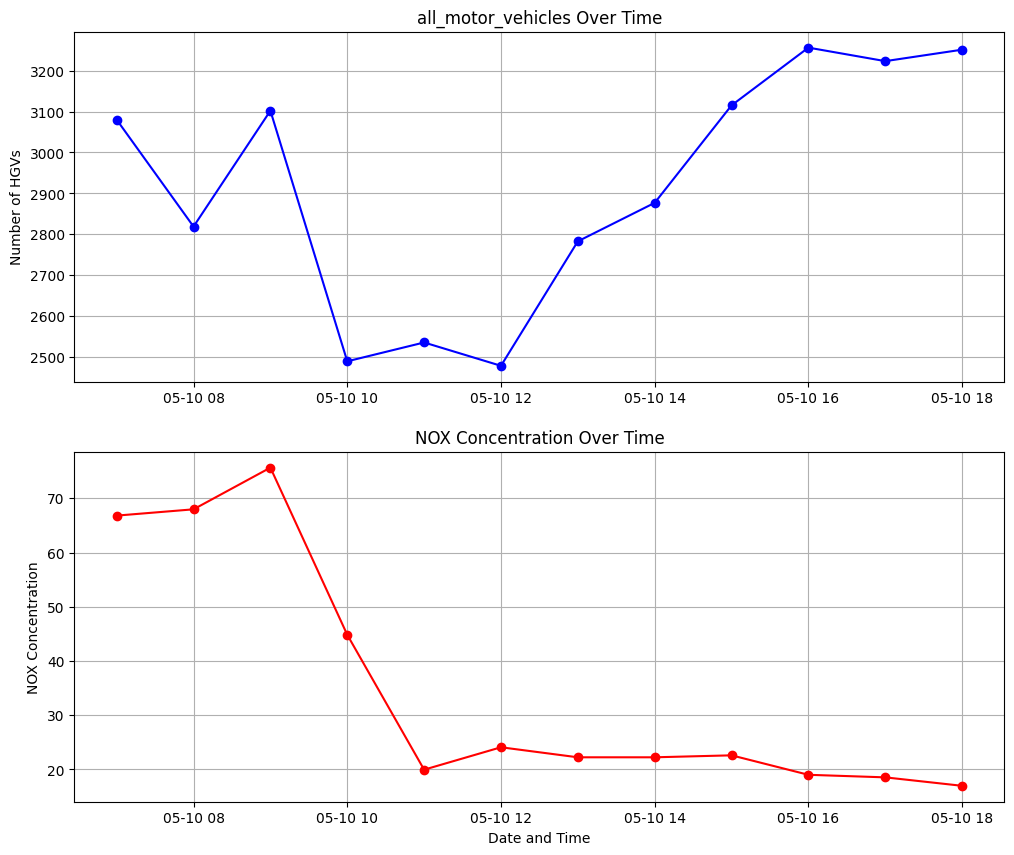

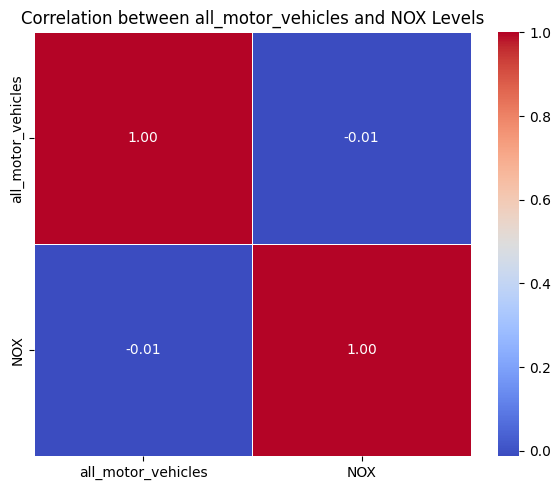

In [267]:
pollution_sensor_inside_caz = 500
traffic_sensor_inside_caz_before = 36409

show_graph_comparision(traffic_sensor_inside_caz_before, pollution_sensor_inside_caz, 2022, 'all_motor_vehicles')

#### Comparision of the number of motor vehicles and pollution levels inside CAZ after CAZ implementation

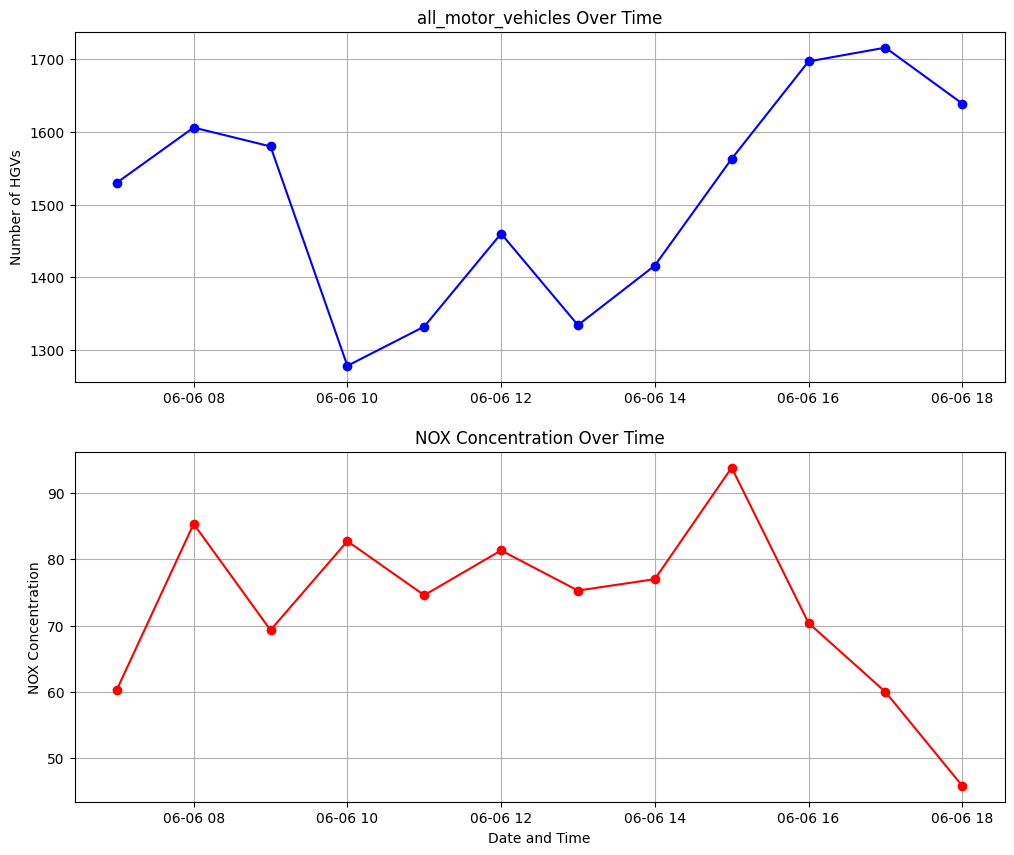

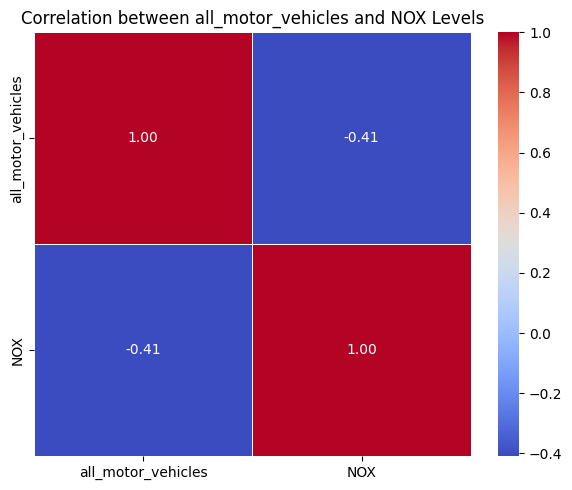

In [268]:
traffic_sensor_inside_caz_after = 74772
show_graph_comparision(traffic_sensor_inside_caz_after, pollution_sensor_inside_caz, 2023, 'all_motor_vehicles')

#### Comparision of the number of motor vehicles and pollution levels outside CAZ before CAZ implementation

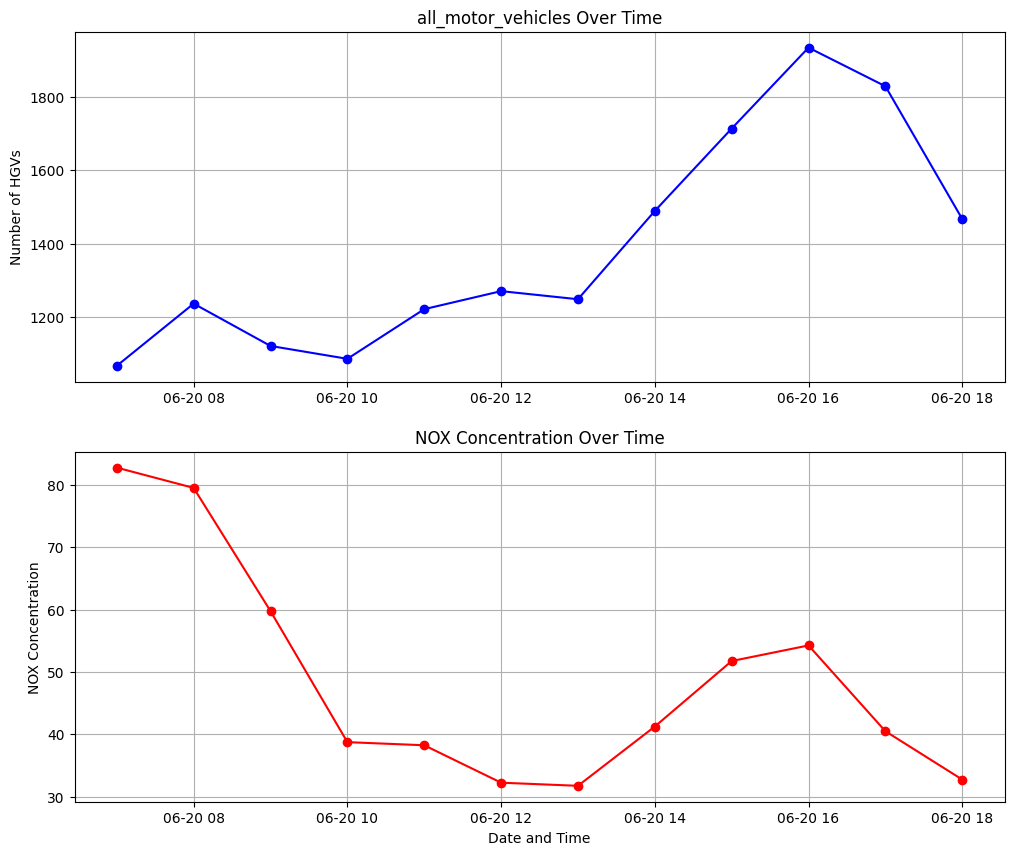

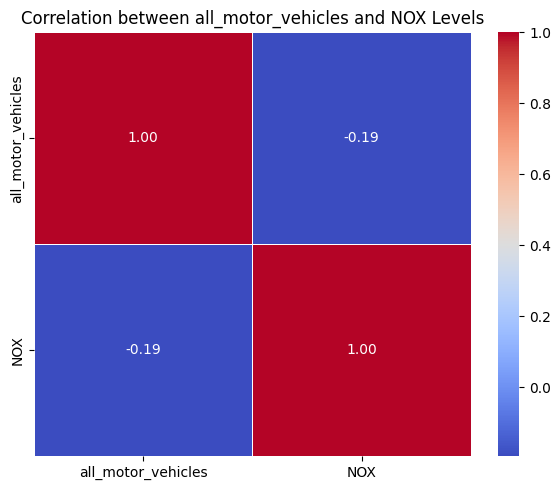

In [269]:
pollution_sensor_outside_caz = 215
traffic_sensor_outside_caz_before = 8390

show_graph_comparision(traffic_sensor_outside_caz_before, pollution_sensor_outside_caz, 2022, 'all_motor_vehicles')

#### Comparision of the number of motor vehicles and pollution levels outside CAZ after CAZ implementation

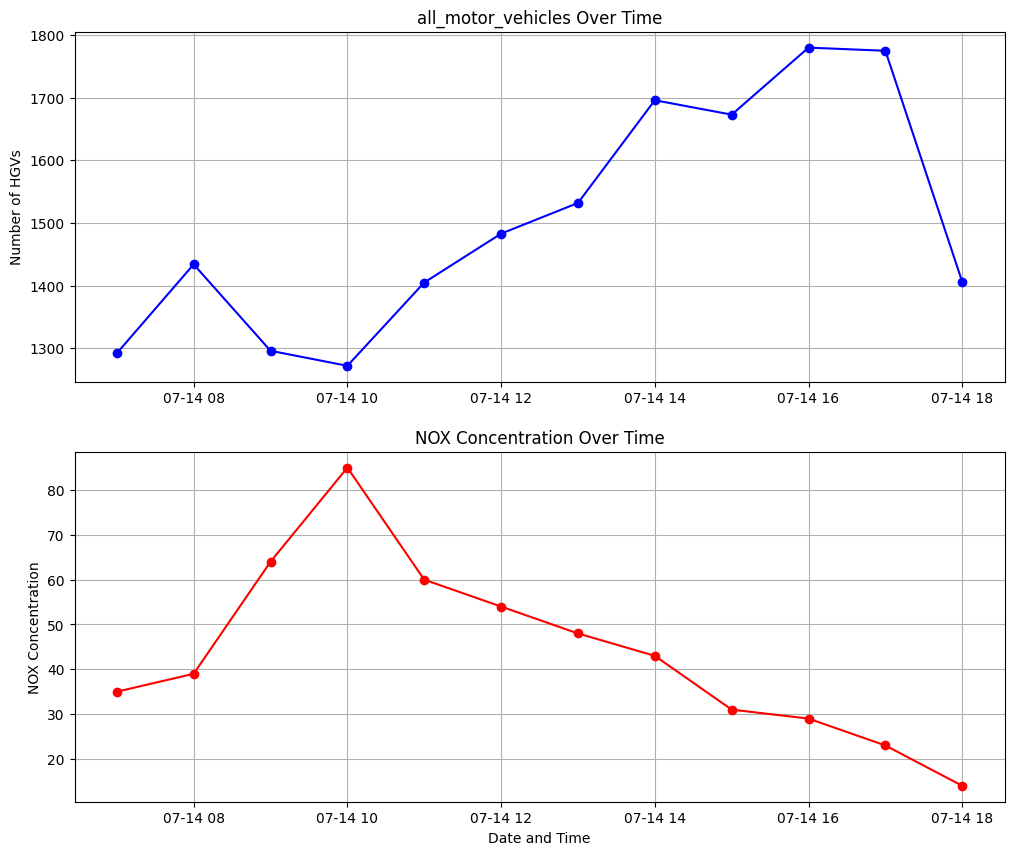

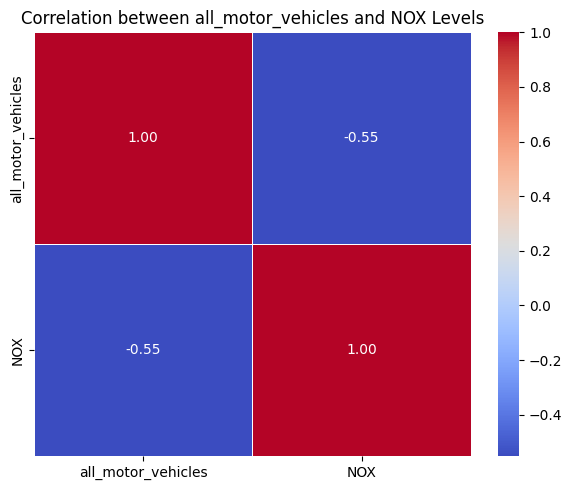

In [270]:
traffic_sensor_outside_caz_after = 38142

show_graph_comparision(traffic_sensor_outside_caz_after, pollution_sensor_outside_caz, 2023, 'all_motor_vehicles')

# HGVs

#### Comparision of the number of Heavy Goods Vehicles and pollution levels inside CAZ before CAZ implementation

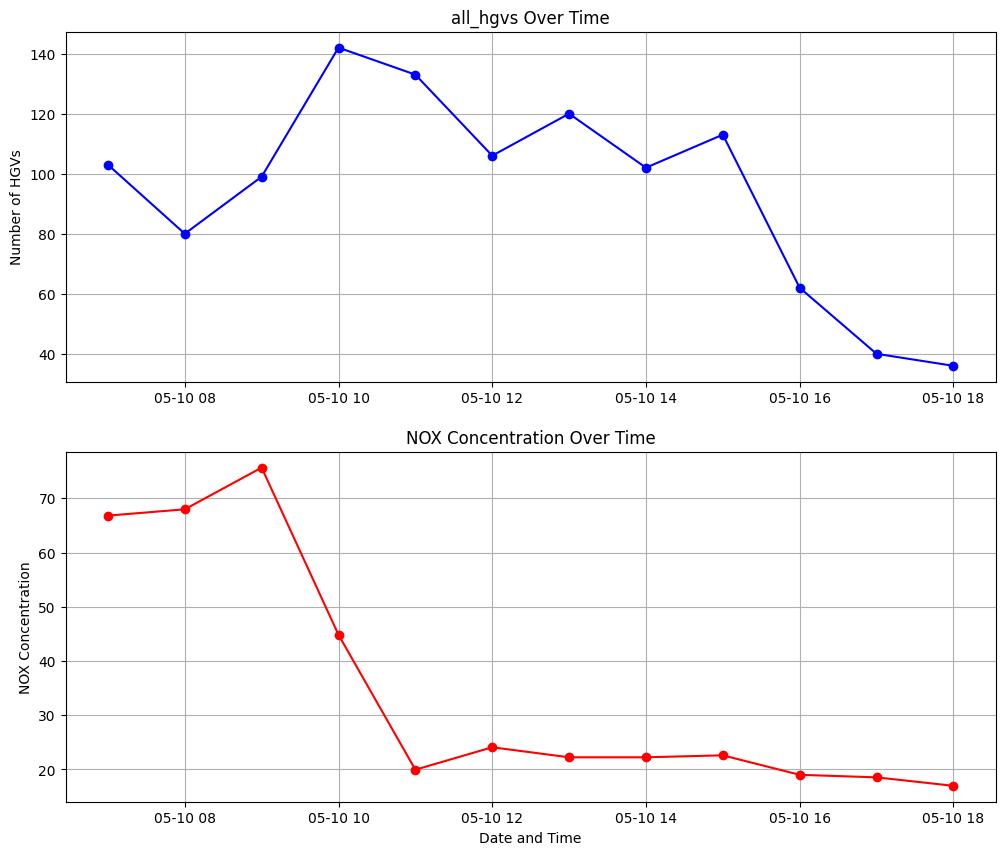

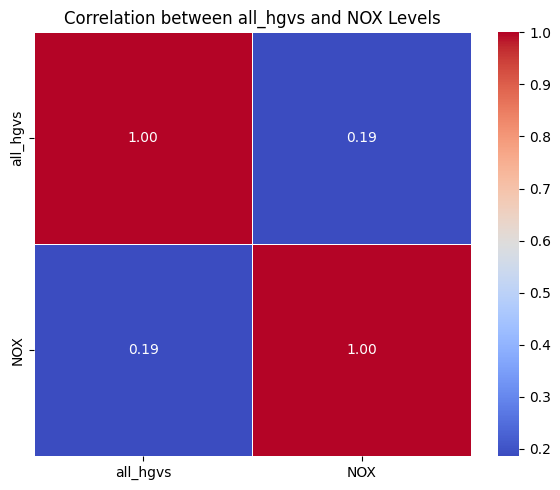

In [271]:
pollution_sensor_inside_caz = 500
traffic_sensor_inside_caz_before = 36409

show_graph_comparision(traffic_sensor_inside_caz_before, pollution_sensor_inside_caz, 2022, 'all_hgvs')

#### Comparision of the number of Heavy Goods Vehicles and pollution levels inside CAZ after CAZ implementation

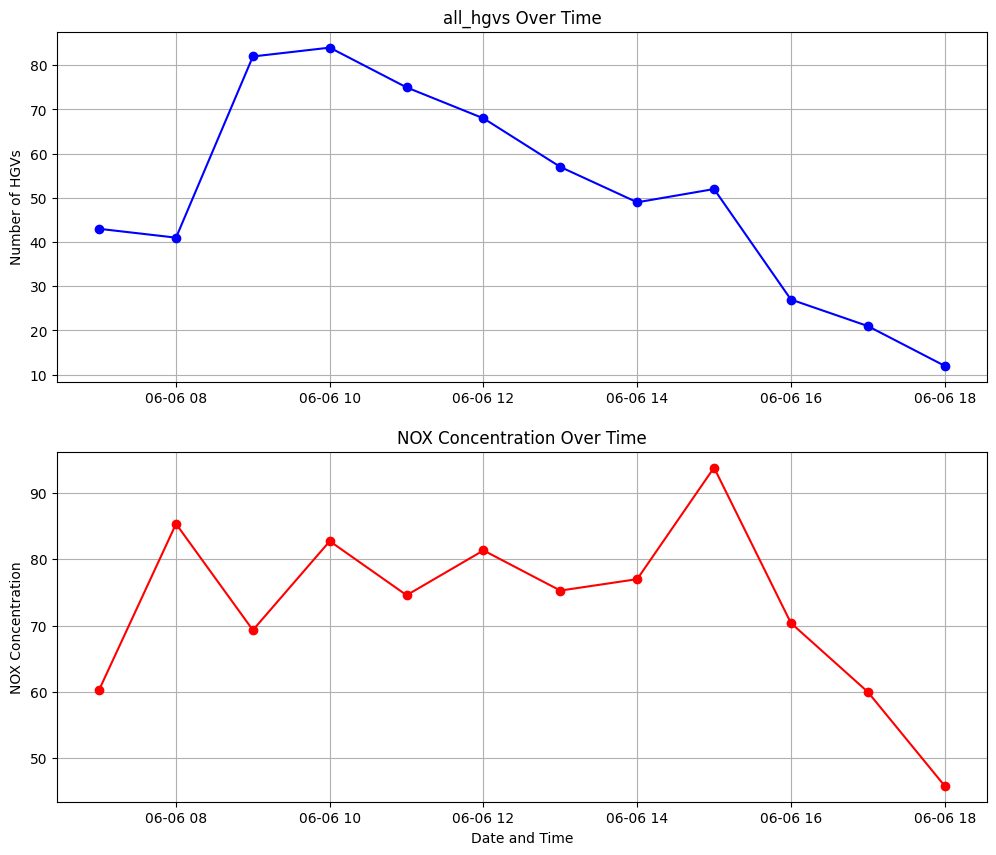

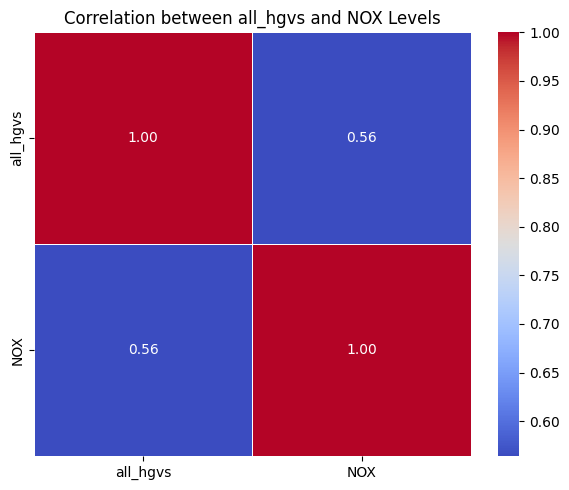

In [272]:
traffic_sensor_inside_caz_after = 74772
show_graph_comparision(traffic_sensor_inside_caz_after, pollution_sensor_inside_caz, 2023, 'all_hgvs')

#### Comparision of the number of Heavy Goods Vehicles and pollution levels outside CAZ before CAZ implementation

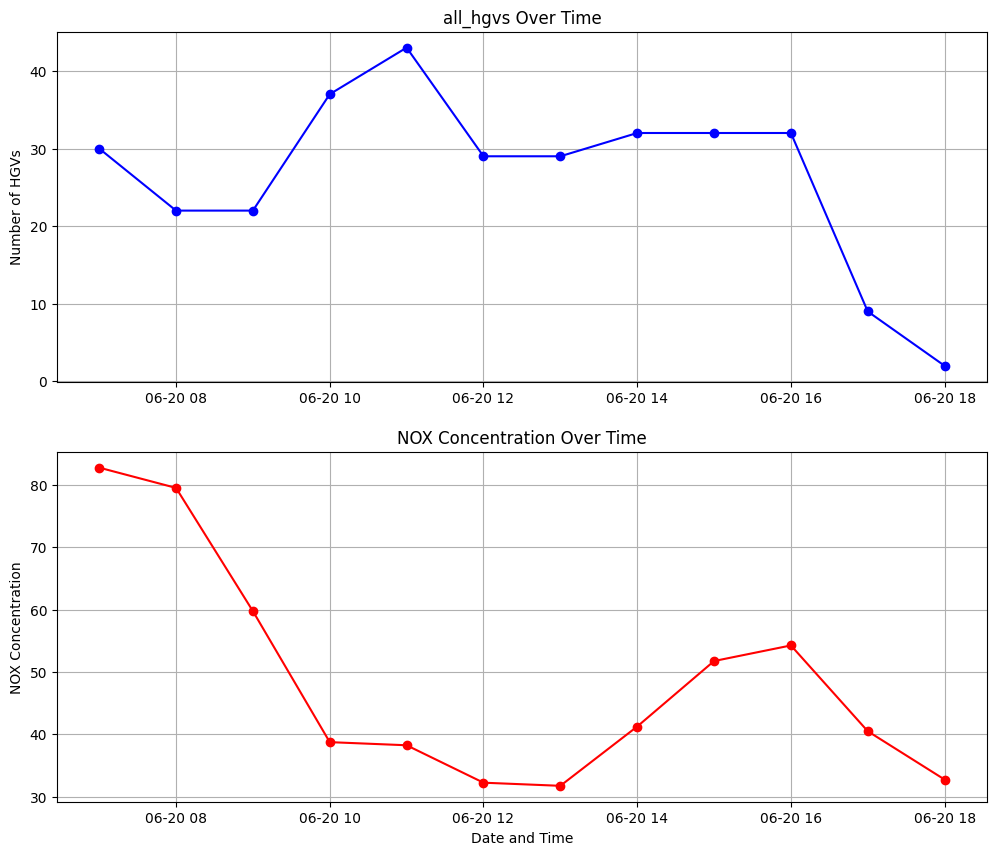

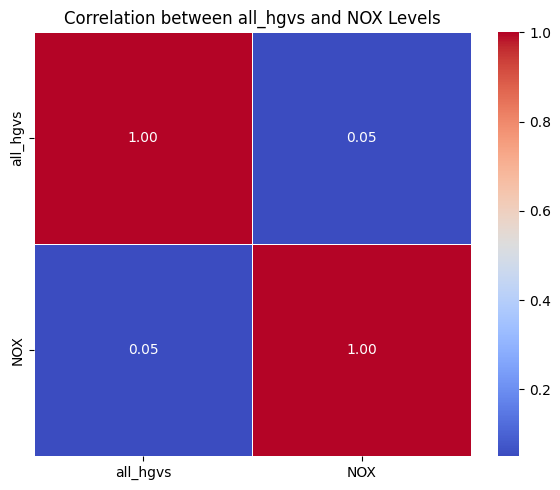

In [273]:
pollution_sensor_outside_caz = 215
traffic_sensor_outside_caz_before = 8390

show_graph_comparision(traffic_sensor_outside_caz_before, pollution_sensor_outside_caz, 2022, 'all_hgvs')

#### Comparision of the number of Heavy Goods Vehicles and pollution levels outside CAZ after CAZ implementation

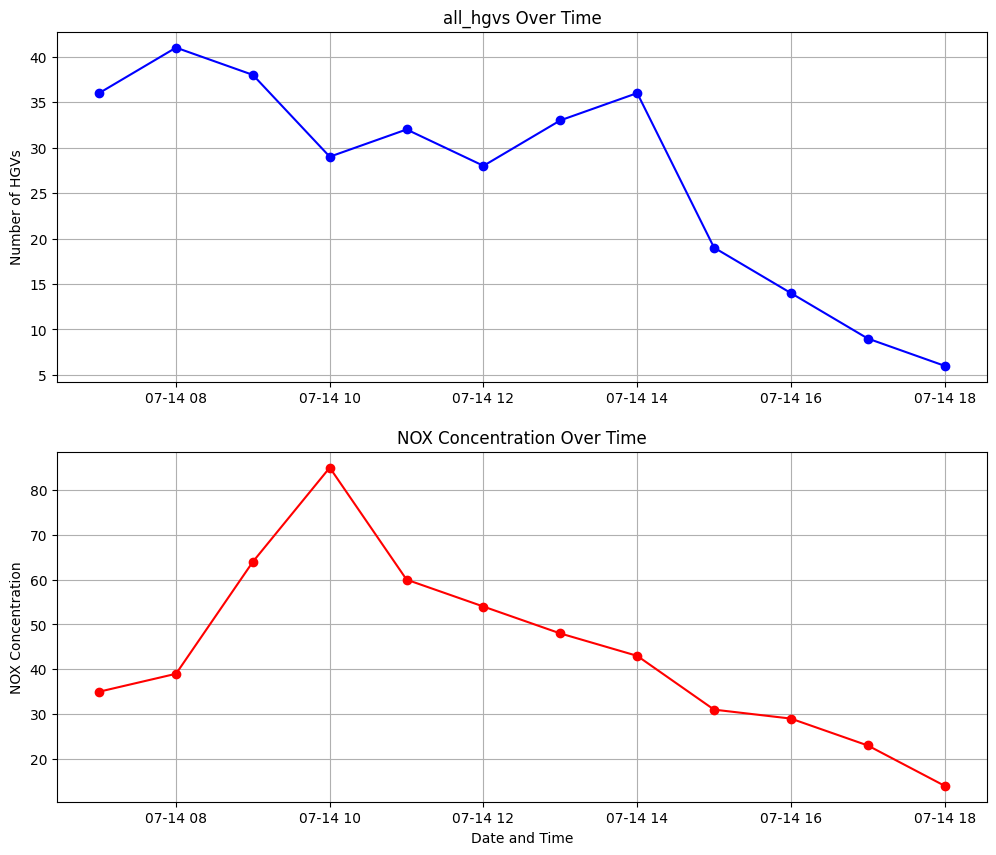

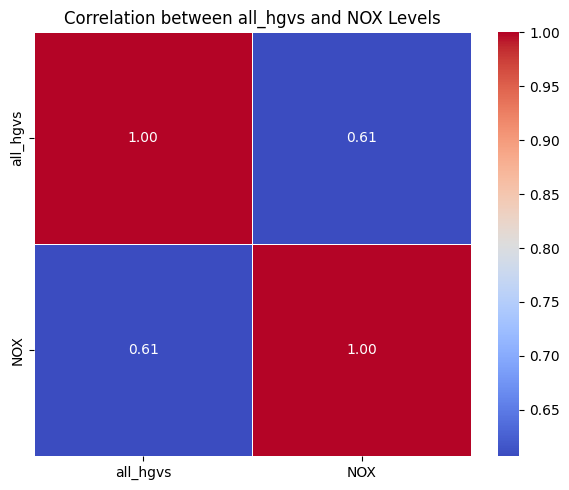

In [274]:
traffic_sensor_outside_caz_after = 38142

show_graph_comparision(traffic_sensor_outside_caz_after, pollution_sensor_outside_caz, 2023, 'all_hgvs')